In [51]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%metal_heading Tutorial 1: Create a single transmon qubit and analyze it using pyEPR.

In [3]:
%metal_print Part 1. Finite Element Eigenmode Analysis

# Create the design in Metal

In [87]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'
hfss = design.renderers.hfss

gui = MetalGUI(design)

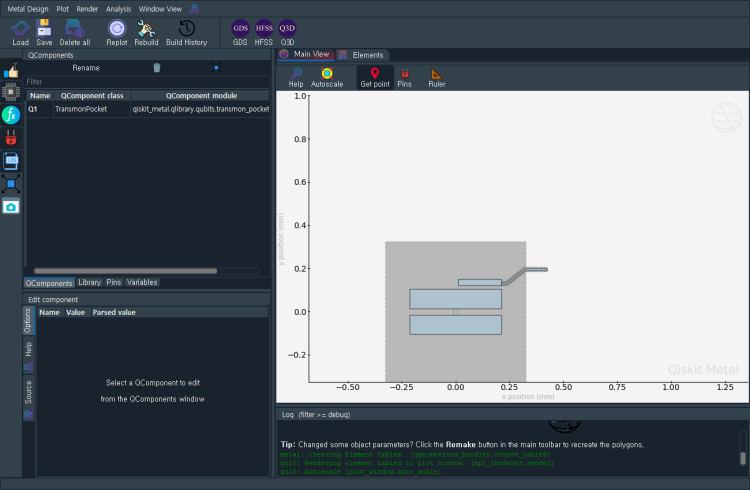

In [5]:
#Create a single transmon with one readout resonator and move it to the center of the chip previously defined.
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

gui.rebuild()
gui.autoscale()
gui.screenshot()

# Establish a connection between Metal and Ansys

In [6]:
hfss.open_ansys(path_var='ANSYSEM_ROOT211')

In [7]:
hfss.connect_ansys()

INFO 12:08PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:08PM [load_ansys_project]: 	Opened Ansys App
INFO 12:08PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 12:08PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 12:08PM [connect_design]: 	Opened active design
	Design:    TransmonQubit [Solution type: Eigenmode]
INFO 12:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:08PM [connect]: 	Connected to project "Project1" and design "TransmonQubit" 😀 



# Prepare and run the analysis

In [10]:
hfss.activate_eigenmode_design("TransmonQubit")

11:26AM 38s WARNING [activate_eigenmode_design]: The name=TransmonQubit was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 11:26AM [connect_design]: 	Opened active design
	Design:    TransmonQubit [Solution type: Eigenmode]
WARNING 11:26AM [connect_setup]: 	No design setup detected.
WARNING 11:26AM [connect_setup]: 	Creating eigenmode default setup.
INFO 11:26AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


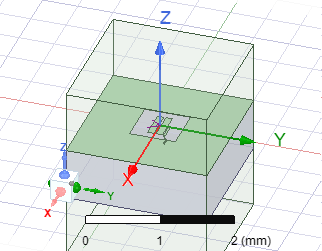

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [11]:
hfss.render_design(['Q1'], box_plus_buffer=False)
hfss.save_screenshot()

In [12]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')


Number of eigenmodes to find             = 1
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



'Cj'

In [16]:
hfss.disconnect_ansys()

AssertionError: It does not appear that you have connected to HFSS yet.            Use the connect()  method. 🤢

In [ ]:
#submit the job
setup.analyze()

In [ ]:
#project 열고 여기에 connect 하기

In [17]:
hfss.connect_ansys()

INFO 11:34AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:34AM [load_ansys_project]: 	Opened Ansys App
INFO 11:34AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 11:34AM [load_ansys_project]: 	Ansys Project was not found.
	 Project is None.
INFO 11:34AM [connect]: 	Connection to Ansys NOT established.  

INFO 11:34AM [connect]: 	 Project not detected in Ansys. Is there a project in your desktop app? 🤔 

INFO 11:34AM [connect]: 	 Connected to project "None". No design detected


In [8]:
hfss.plot_convergences()

12:08PM 34s INFO [hfss_report_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


# Plot fields and display them

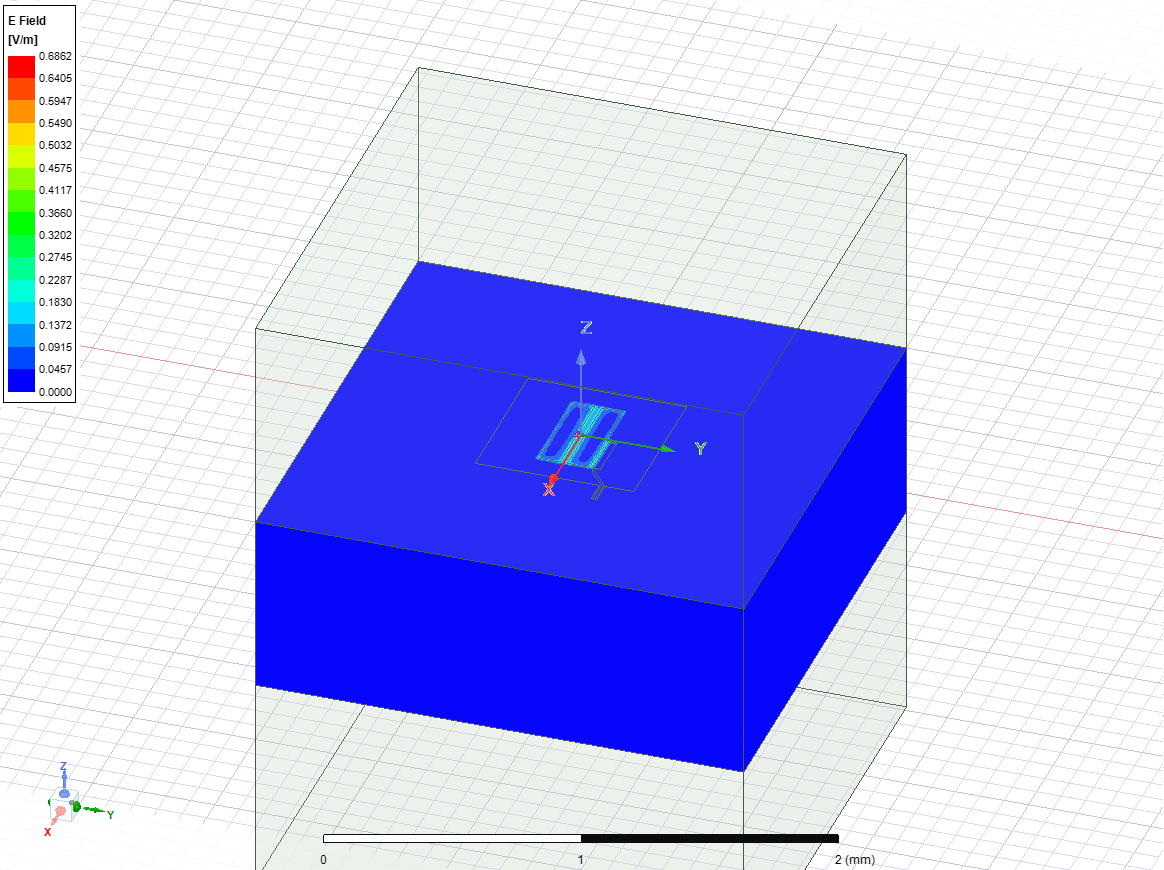

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [9]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [10]:
hfss.plot_ansys_delete(['Mag_E1'])

In [11]:
%metal_print Part 2. Energy-Participation-Ratio Analysis

# Set up EPR parameters
## Specify the junctions in the model; in this case there’s only one, namely ‘jj’.

In [12]:
#Non-linear (Josephson) junction
pinfo = hfss.pinfo # Project info
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj',
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify
# Handles  microwave analysis on eigenmode solutions
eprd = epr.DistributedAnalysis(pinfo)

Design "TransmonQubit" info:
	# eigenmodes    1
	# variations    1


## Find the electric and magnetic energy stored in the substrate and the system as a whole.



In [14]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag    = {ℰ_mag}
""")


ℰ_elec_all       = 1.60167597565924e-24
ℰ_elec_substrate = 1.47551405819653e-24
EPR of substrate = 92.1%

ℰ_mag    = 8.17470620655697e-27



# Run EPR analysis
## Perform EPR analysis for all modes and variations.

In [15]:
eprd.do_EPR_analysis()


Variation 0  [1/1]

  Mode 0 at 6.37 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  8.008e-25 4.087e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.89%
	jj              0.993589  (+)        0.0318424
		(U_tot_cap-U_tot_ind)/mean=1.63%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9212313105896575

ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project1\TransmonQubit\2021-07-13 12-26-59.npz




(WindowsPath('C:/data-pyEPR/Project1/TransmonQubit/2021-07-13 12-26-59.npz'),
 ['0'])

In [16]:
# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

WARNING 01:28PM [__init__]: <p>Error: <class 'IndexError'></p>


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.033279
dtype: float64

Pm_norm idx =
     jj
0  True
*** P (participation matrix, not normlz.)
         jj
0  0.962927

*** S (sign-bit matrix)
   s_jj
0     1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       307

*** Chi matrix ND (MHz) 
       342

*** Frequencies O1 PT (MHz)
0    6063.677947
dtype: float64

*** Frequencies ND (MHz)
0    6047.061444
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


OrderedDict([('0',
              OrderedDict([('f_0', 0    6370.951833
                            Name: 0, dtype: float64),
                           ('f_1', 0    6063.677947
                            dtype: float64),
                           ('f_ND',
                            0    6047.061444
                            dtype: float64),
                           ('chi_O1',
                                        0
                            0  307.273886),
                           ('chi_ND',
                                        0
                            0  342.071421),
                           ('ZPF', array([[0.44033685]])),
                           ('Pm_normed', array([[0.99497291]])),
                           ('Pm_raw',
                            0    0.962927
                            Name: jj, dtype: float64),
                           ('_Pm_norm',
                            modes
                            0    1.033279
                            d

In [18]:
# 4b. Report solved results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,6063.68


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj,,
10,0,342.07


In [19]:
hfss.disconnect_ansys()

In [20]:
%metal_heading Tutorial 2: Create and perform EPR analysis on a CPW resonator.

In [21]:
%metal_print Part 1. Finite Element Eigenmode Analysis

## Update the design in Metal
### Connect the transmon to a CPW. The other end of the CPW connects to an open to ground termination.

In [22]:
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
RouteMeander(design, 'readout',  Dict(
        total_length='6 mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = dict(start_straight='100um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

## Render the resonator Design in Ansys

In [23]:
hfss.connect_ansys()

INFO 01:50PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:50PM [load_ansys_project]: 	Opened Ansys App
INFO 01:50PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:50PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 01:50PM [connect_design]: 	Opened active design
	Design:    TransmonQubit [Solution type: Eigenmode]
INFO 01:50PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:50PM [connect]: 	Connected to project "Project1" and design "TransmonQubit" 😀 



In [24]:
hfss.activate_eigenmode_design("Readout")
# create and activate a separate eigenmode design called “Readout”.

01:51PM 25s WARNING [activate_eigenmode_design]: The name=Readout was not in active project.  A new design will be inserted to the project.  Names in active project are: 
['TransmonQubit'].  
INFO 01:51PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
WARNING 01:51PM [connect_setup]: 	No design setup detected.
WARNING 01:51PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:51PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


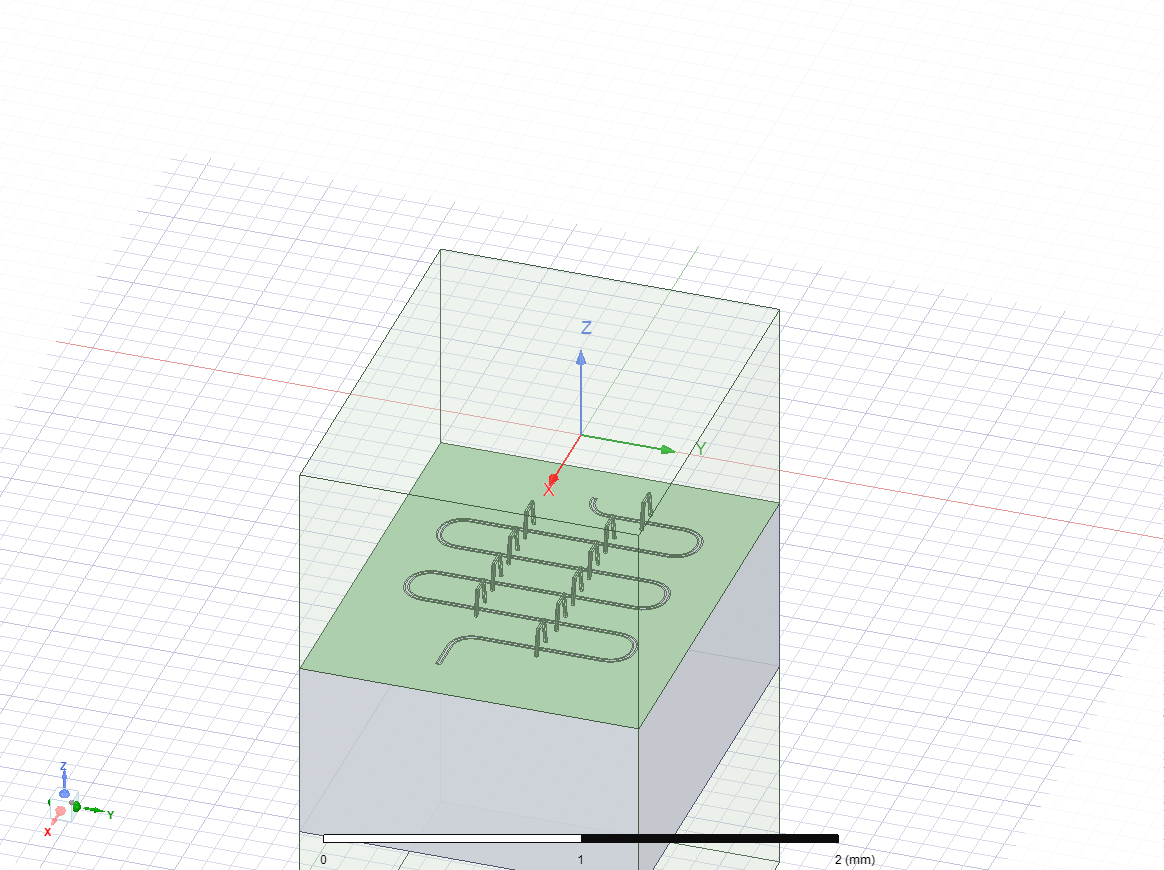

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [25]:
hfss.render_design(['readout', 'open_to_ground'], [('readout', 'start'), ('readout', 'end')])
hfss.save_screenshot()

## Prepare and run the analysis, then plot E-field

In [38]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')


Number of eigenmodes to find             = 1
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



'Cj'

In [32]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [33]:
hfss.connect_ansys()

INFO 02:51PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:51PM [load_ansys_project]: 	Opened Ansys App
INFO 02:51PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:51PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 02:51PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 02:51PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:51PM [connect]: 	Connected to project "Project1" and design "Readout" 😀 



In [ ]:
#submit the job
setup.analyze()

In [29]:
hfss.plot_convergences()

02:45PM 38s INFO [hfss_report_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


In [30]:
eprd = epr.DistributedAnalysis(hfss.pinfo)
eprd.get_ansys_frequencies_all()

Design "Readout" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,9.69648,inf


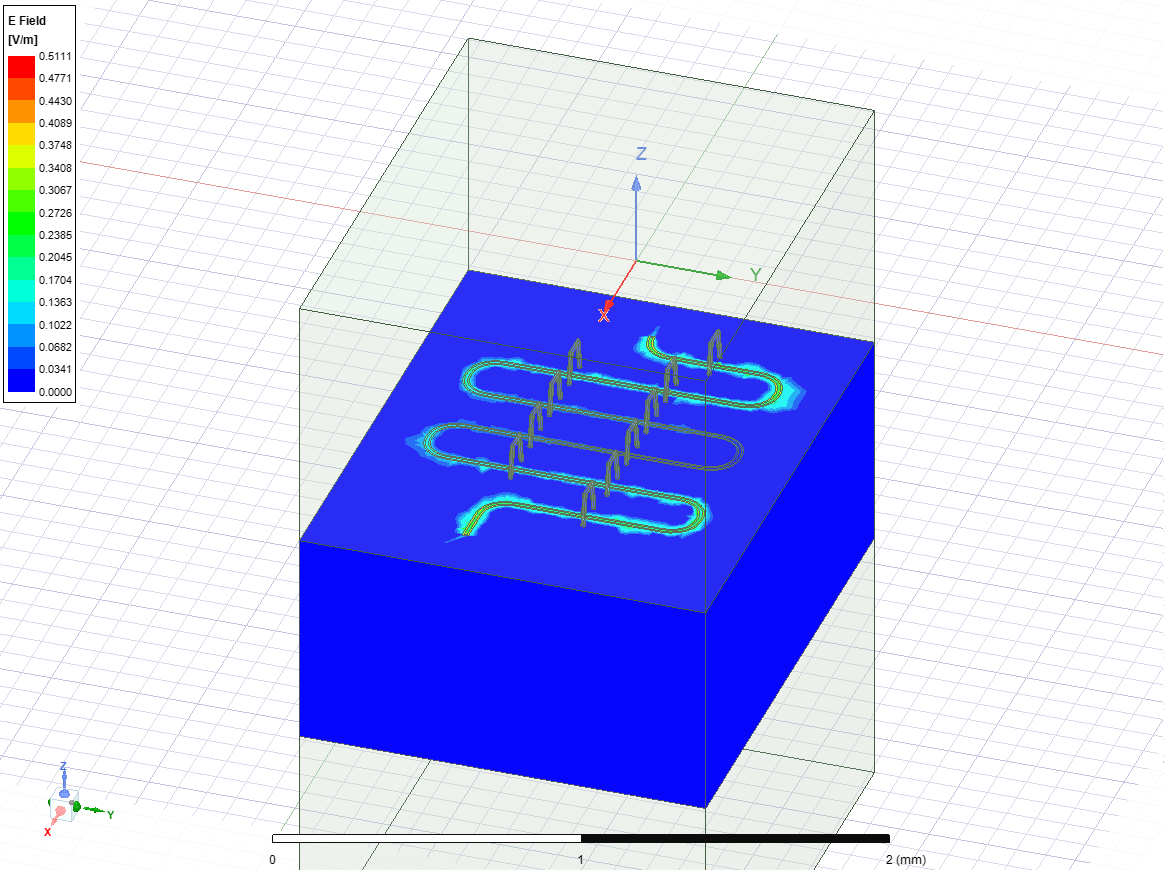

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [34]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [35]:
hfss.plot_ansys_delete(['Mag_E1'])

In [39]:
#Try again with a larger number of steps (better convergence)
#Display the Ansys modeler window again and plot the E-field on the chip’s surface with this updated number of passes.
#Note that the bright areas have become much smoother compared to the previous image, indicating better convergence.
setup.passes = 15

In [44]:
hfss.disconnect_ansys()

In [46]:
hfss.connect_ansys()

INFO 03:14PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:14PM [load_ansys_project]: 	Opened Ansys App
INFO 03:14PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 03:14PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 03:14PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 03:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:14PM [connect]: 	Connected to project "Project1" and design "Readout" 😀 



In [47]:
hfss.plot_convergences()

03:14PM 55s INFO [hfss_report_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


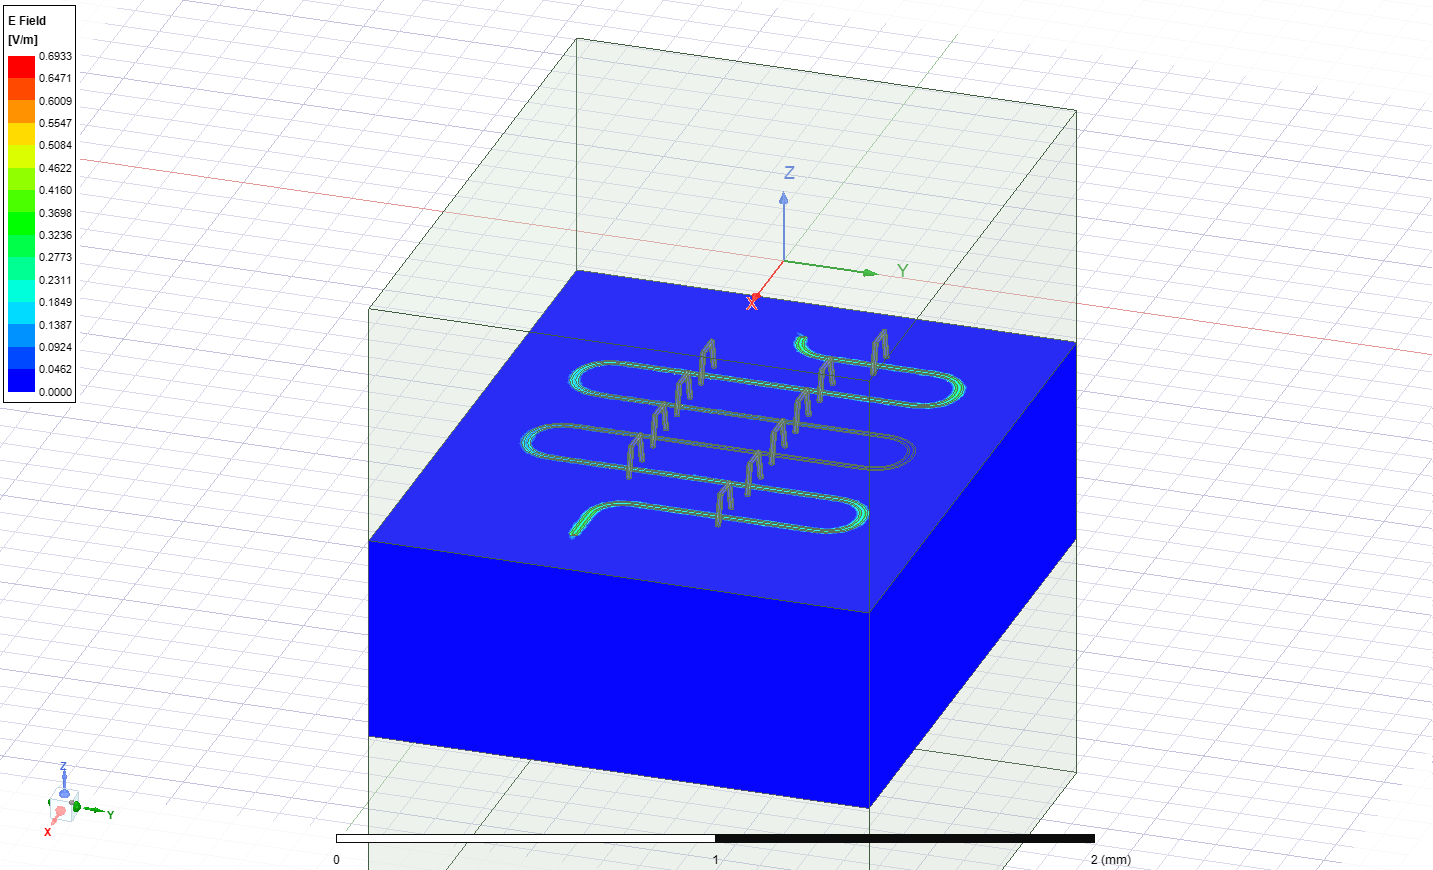

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [48]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [49]:
%metal_print Part 2. Energy-Participation-Ratio Analysis

In [53]:
eprd = epr.DistributedAnalysis(hfss.pinfo)
eprd.get_ansys_frequencies_all()

Design "Readout" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,9.847353,inf


In [54]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")


ℰ_elec_all       = 2.05601274530773e-24
ℰ_elec_substrate = 1.88645303531968e-24
EPR of substrate = 91.8%

ℰ_mag_all       = 2.0562770955216e-24
ℰ_mag % of ℰ_elec_all  = 100.0%



In [55]:
hfss.disconnect_ansys()

In [56]:
%metal_heading Tutorial 3: Analyze the combined transmon + CPW resonator system.

In [57]:
%metal_print Part 1. Finite Element Eigenmode Analysis

In [58]:
hfss.connect_ansys()

INFO 03:22PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:22PM [load_ansys_project]: 	Opened Ansys App
INFO 03:22PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 03:22PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 03:22PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 03:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:22PM [connect]: 	Connected to project "Project1" and design "Readout" 😀 



In [59]:
hfss.activate_eigenmode_design("TransmonResonator")

03:23PM 10s WARNING [activate_eigenmode_design]: The name=TransmonResonator was not in active project.  A new design will be inserted to the project.  Names in active project are: 
['TransmonQubit', 'Readout'].  
INFO 03:23PM [connect_design]: 	Opened active design
	Design:    TransmonResonator [Solution type: Eigenmode]
WARNING 03:23PM [connect_setup]: 	No design setup detected.
WARNING 03:23PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


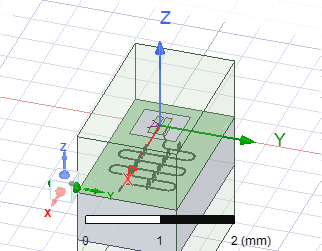

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [60]:
hfss.render_design(['Q1', 'readout', 'open_to_ground'], [('readout', 'end')])
hfss.save_screenshot()

In [61]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')


Number of eigenmodes to find             = 2
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



'Cj'

In [62]:
hfss.disconnect_ansys()

In [77]:
hfss.connect_ansys()

INFO 04:10PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:10PM [load_ansys_project]: 	Opened Ansys App
INFO 04:10PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:10PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 04:10PM [connect_design]: 	Opened active design
	Design:    TransmonResonator [Solution type: Eigenmode]
INFO 04:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:10PM [connect]: 	Connected to project "Project1" and design "TransmonResonator" 😀 



In [64]:
hfss.plot_convergences()

03:29PM 10s INFO [hfss_report_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


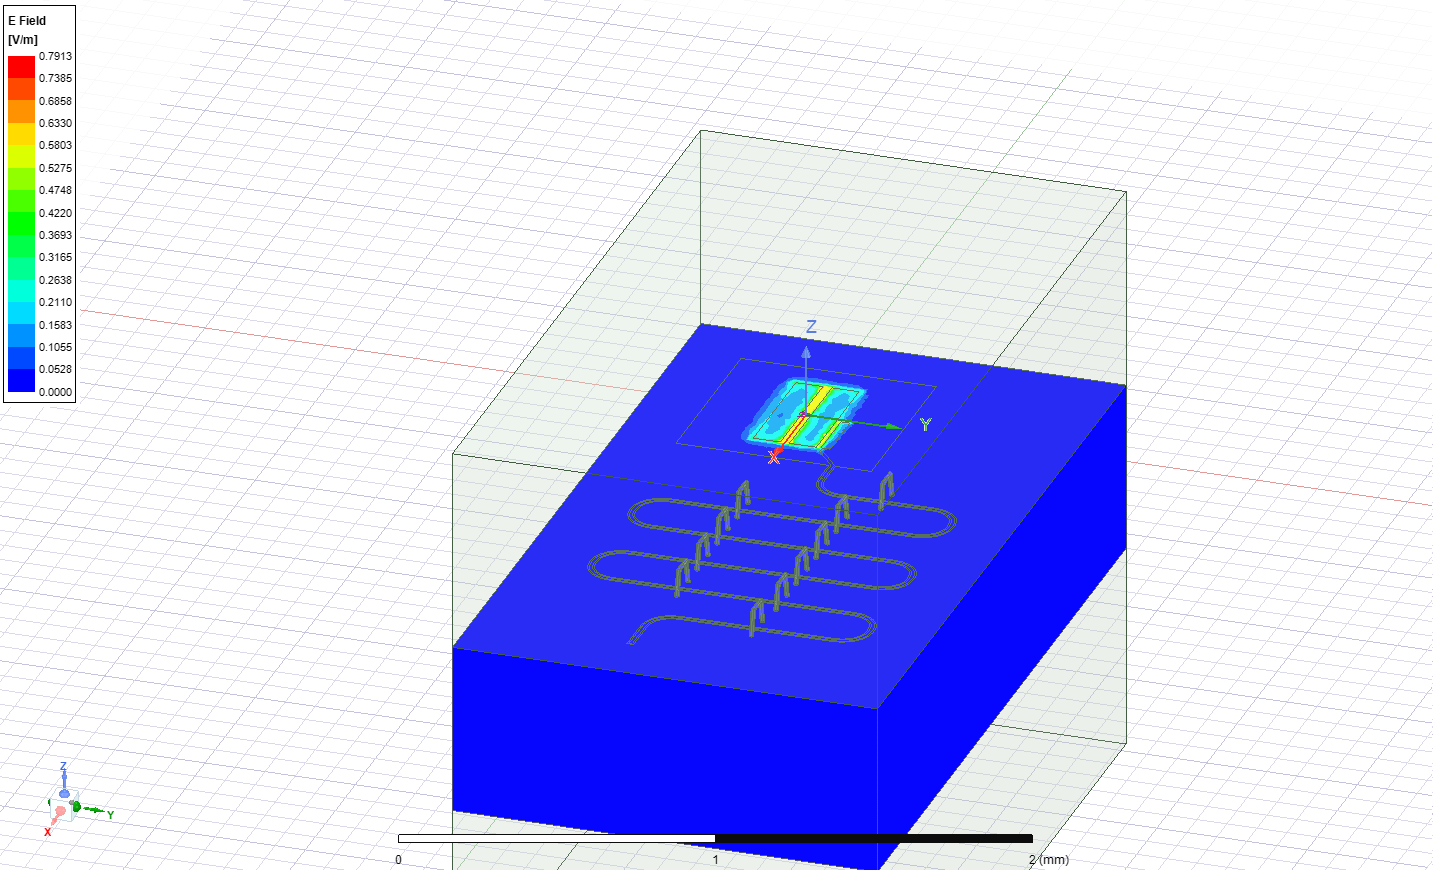

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [65]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [66]:
hfss.plot_ansys_delete(['Mag_E1'])

In [67]:
%metal_print Part 2. Energy-Participation-Ratio Analysis


In [68]:
#Non-linear (Josephson) junction
pinfo = hfss.pinfo
pinfo.junctions['jj'] = {'Lj_variable': 'Lj',  'rect': 'JJ_rect_Lj_Q1_rect_jj',
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify

In [69]:
# Handles  microwave analysis on eigenmode solutions
eprd = epr.DistributedAnalysis(pinfo)

Design "TransmonResonator" info:
	# eigenmodes    2
	# variations    1


In [70]:
eprd = epr.DistributedAnalysis(pinfo)
eprd.set_mode(1)

Design "TransmonResonator" info:
	# eigenmodes    2
	# variations    1


In [71]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")


ℰ_elec_all       = 5.49128252343262e-24
ℰ_elec_substrate = 4.99851182709998e-24
EPR of substrate = 91.0%

ℰ_mag_all       = 5.47952524012073e-24
ℰ_mag % of ℰ_elec_all  = 99.8%



In [73]:
eprd.set_mode(0)

In [74]:
eprd.do_EPR_analysis()



Variation 0  [1/1]

  Mode 0 at 6.12 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%   1.08e-23 8.404e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.13%
	jj              0.991567  (+)        0.0292832
		(U_tot_cap-U_tot_ind)/mean=1.48%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9086753429437069

  Mode 1 at 9.30 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.2%  2.746e-24  2.74e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 93.61%
	jj              0.00274125  (+)        0.00018718
		(U_tot_cap-U_tot_ind)/mean=-0.02%
Calculating Qdielectric

(WindowsPath('C:/data-pyEPR/Project1/TransmonResonator/2021-07-13 15-57-53.npz'),
 ['0'])

In [75]:
# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

WARNING 04:06PM [__init__]: <p>Error: <class 'IndexError'></p>


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.030077
1    0.924480
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  0.963357
1  0.002741

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
    0.0027

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       282     2.37
      2.37  0.00497

*** Chi matrix ND (MHz) 
       313     2.04
      2.04   0.0037

*** Frequencies O1 PT (MHz)
0    5832.960832
1    9298.334485
dtype: float64

*** Frequencies ND (MHz)
0    5818.217351
1    9298.377083
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


OrderedDict([('0',
              OrderedDict([('f_0', 0    6115.796676
                            1    9299.522311
                            Name: 0, dtype: float64),
                           ('f_1',
                            0    5832.960832
                            1    9298.334485
                            dtype: float64),
                           ('f_ND',
                            0    5818.217351
                            1    9298.377083
                            dtype: float64),
                           ('chi_O1',
                                        0         1
                            0  281.652986  2.365717
                            1    2.365717  0.004968),
                           ('chi_ND',
                                        0         1
                            0  312.996183  2.040914
                            1    2.040914  0.003703),
                           ('ZPF',
                            array([[0.43085606],
             

In [78]:
# 4b. Report solved results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,5832.96
1,9298.33


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj                    
10 0  313.00  2.04e+00
   1    2.04  3.70e-03

In [79]:
hfss.disconnect_ansys()

In [80]:
%metal_heading Tutorial 4: Analyze a coupled 2 transmon system.

In [81]:

%metal_print Part 1. Finite Element Eigenmode Analysis

In [93]:
hfss.connect_ansys()

INFO 04:20PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:20PM [load_ansys_project]: 	Opened Ansys App
INFO 04:20PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:20PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 04:20PM [connect_design]: 	Opened active design
	Design:    TwoTransmon [Solution type: Eigenmode]
INFO 04:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:20PM [connect]: 	Connected to project "Project1" and design "TwoTransmon" 😀 



In [83]:
hfss.activate_eigenmode_design("TwoTransmon")

04:15PM 03s WARNING [activate_eigenmode_design]: The name=TwoTransmon was not in active project.  A new design will be inserted to the project.  Names in active project are: 
['TransmonResonator', 'Readout', 'TransmonQubit'].  
INFO 04:15PM [connect_design]: 	Opened active design
	Design:    TwoTransmon [Solution type: Eigenmode]
WARNING 04:15PM [connect_setup]: 	No design setup detected.
WARNING 04:15PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [88]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x = '1.0 mm',
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1,loc_H=+1, pad_width='200um')
    )))

coupler = RouteStraight(design, 'coupler', Dict(hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='Q2', pin='readout')), ))

gui.rebuild()
gui.autoscale()

In [89]:
hfss.options['x_buffer_width_mm'] = 0.5
hfss.options['y_buffer_width_mm'] = 0.5
hfss.options['wb_threshold'] = '100um'
hfss.options['wb_size'] = 5
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'ansys_file_extension': '.aedt',
 'x_buffer_width_mm': 0.5,
 'y_buffer_width_mm': 0.5,
 'wb_threshold': '100um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [90]:
qcomps = design.components
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
qcomps['Q2'].options['hfss_inductance'] = 'Lj2'
qcomps['Q2'].options['hfss_capacitance'] = 'Cj2'
gui.rebuild()

In [91]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,1,rect_jj,"LINESTRING (0.00000 -0.01500, 0.00000 0.01500)",1,False,False,main,0.02,Lj1,Cj1,0,0.000007,10nH,0,0,0.000007,my_other_junction
1,2,rect_jj,"LINESTRING (1.00000 -0.01500, 1.00000 0.01500)",1,False,False,main,0.02,Lj2,Cj2,0,0.000007,10nH,0,0,0.000007,my_other_junction


In [94]:
hfss.set_mode(1, "Setup")

INFO 04:21PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


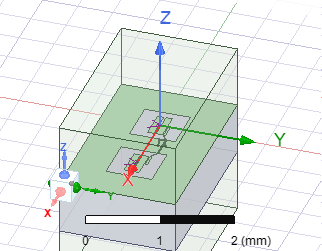

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [95]:
hfss.render_design(['coupler', 'Q1', 'Q2'], [])
hfss.save_screenshot()

In [106]:
setup = hfss.pinfo.setup
setup.passes = 15
setup.delta_f = 0.05
setup.n_modes = 2

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj1', '13 nH')
pinfo.design.set_variable('Cj1', '0 fF')
pinfo.design.set_variable('Lj2', '9 nH')
pinfo.design.set_variable('Cj2', '0 fF')


'Cj2'

In [98]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [100]:
hfss.connect_ansys()

INFO 04:28PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:28PM [load_ansys_project]: 	Opened Ansys App
INFO 04:28PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:28PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 04:28PM [connect_design]: 	Opened active design
	Design:    TwoTransmon [Solution type: Eigenmode]
INFO 04:28PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:28PM [connect]: 	Connected to project "Project1" and design "TwoTransmon" 😀 



In [101]:
hfss.plot_convergences()

04:28PM 18s INFO [hfss_report_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


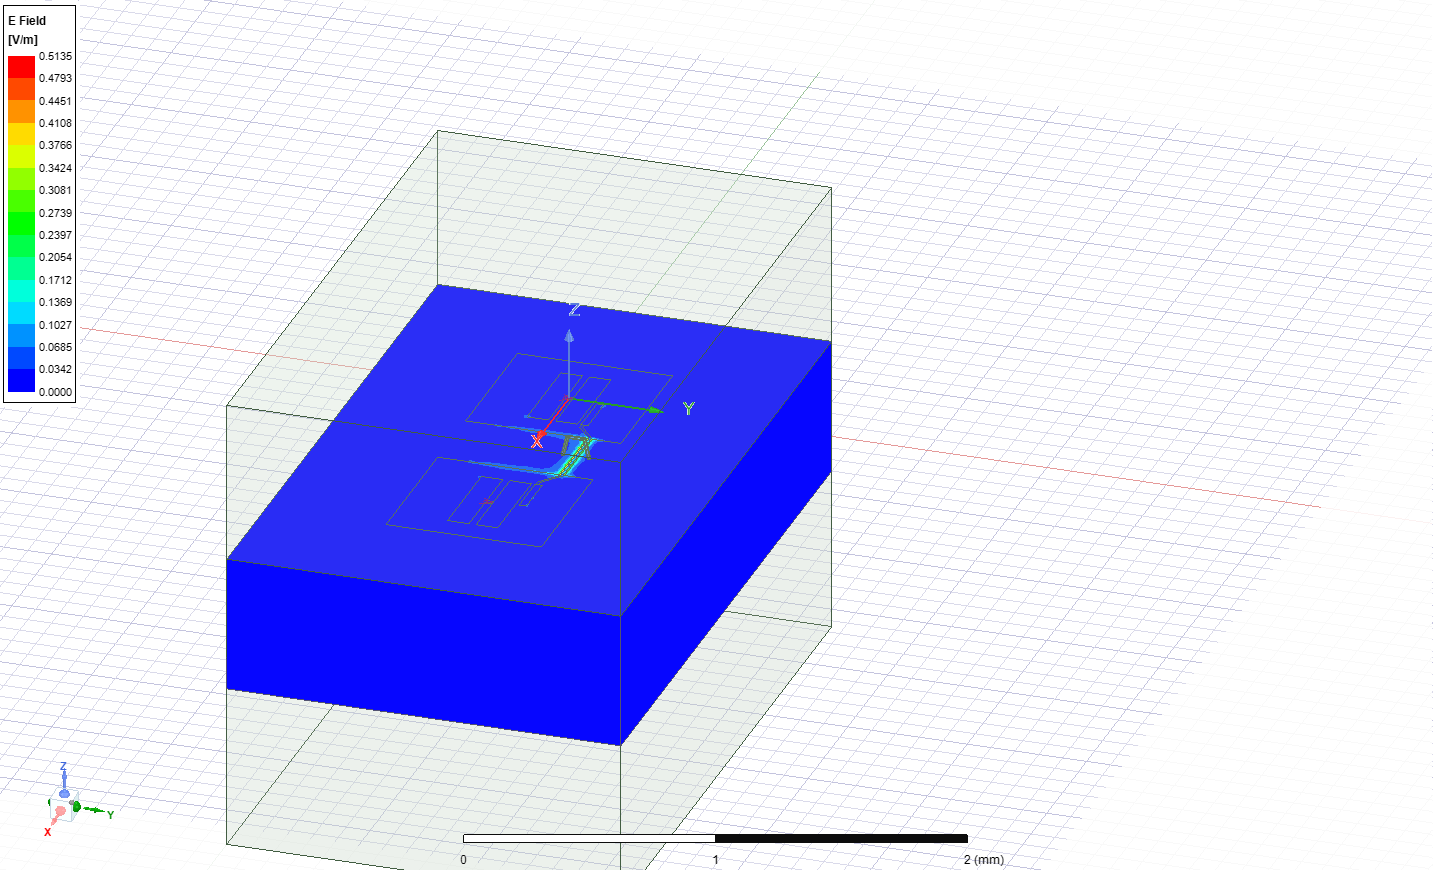

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [102]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [103]:
hfss.plot_ansys_delete(['Mag_E1'])

In [104]:
%metal_print Part 2. Energy-Participation-Ratio Analysis

In [107]:
#Non-linear (Josephson) junction
pinfo.junctions['jj1'] = {'Lj_variable': 'Lj1',  'rect': 'JJ_rect_Lj_Q1_rect_jj',
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj1'}
pinfo.junctions['jj2'] = {'Lj_variable': 'Lj2',  'rect': 'JJ_rect_Lj_Q2_rect_jj',
                             'line': 'JJ_Lj_Q2_rect_jj_',  'Cj_variable': 'Cj2'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify
# Handles  microwave analysis on eigenmode solutions
eprd = epr.DistributedAnalysis(pinfo)

Design "TwoTransmon" info:
	# eigenmodes    2
	# variations    1


In [108]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")


ℰ_elec_all       = 1.42019771057775e-23
ℰ_elec_substrate = 1.36186897109927e-23
EPR of substrate = 95.9%

ℰ_mag_all       = 1.42019764927374e-23
ℰ_mag % of ℰ_elec_all  = 100.0%



## Perform EPR analysis for all modes and variations.

In [109]:
eprd.do_EPR_analysis()


Variation 0  [1/1]

  Mode 0 at 36.39 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  7.101e-24 7.101e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 42.39%
	jj1             9.09402e-17  (+)        1.23582e-16
		Energy fraction (Lj over Lj&Cj)= 51.53%
	jj2             1.84115e-16  (+)        1.73216e-16
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9589291413131827

  Mode 1 at 40.88 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               -0.0%  6.606e-24 6.606e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 36.82%
	jj1    

(WindowsPath('C:/data-pyEPR/Project1/TwoTransmon/2021-07-13 16-30-44.npz'),
 ['0'])

In [110]:

# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

WARNING 04:32PM [__init__]: <p>Error: <class 'IndexError'></p>


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    7.846744e+07
1    1.956163e+08
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  9.094017e-17  1.841155e-16
1  1.008111e-16  2.789261e-15

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1      1
1      1      1
*** P (participation matrix, normalized.)
   9.1e-17  1.8e-16
     1e-16  2.8e-15

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  4.18e-28 1.08e-26
  1.08e-26 8.97e-26

*** Chi matrix ND (MHz) 
        -0       -0
        -0       -0

*** Frequencies O1 PT (MHz)
0    36385.868789
1    40883.874663
dtype: float64

*** Frequencies ND (MHz)
0    36385.868789
1    40883.874663
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [

OrderedDict([('0',
              OrderedDict([('f_0', 0    36385.868789
                            1    40883.874663
                            Name: 0, dtype: float64),
                           ('f_1',
                            0    36385.868789
                            1    40883.874663
                            dtype: float64),
                           ('f_ND',
                            0    36385.868789
                            1    40883.874663
                            dtype: float64),
                           ('chi_O1',
                                          0             1
                            0  4.177219e-28  1.078669e-26
                            1  1.078669e-26  8.966812e-26),
                           ('chi_ND',
                                 0    1
                            0 -0.0 -0.0
                            1 -0.0 -0.0),
                           ('ZPF',
                            array([[1.14707860e-08, 1.35803211e-08],
     

In [111]:
# 4b. Report solved results
swp_variable = 'Lj1' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
eigenmode,
0,36385.87
1,40883.87


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0    1
Lj1            
13  0 -0.0 -0.0
    1 -0.0 -0.0

In [112]:
for lj in range(12,16, 1):
    pinfo.design.set_variable('Lj1', f'{lj} nH')

In [114]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [113]:
    pinfo.setup.analyze()

INFO 04:37PM [analyze]: Analyzing setup Setup


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024349), None)

In [115]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [116]:
gui.main_window.close()

True